# Apply ARIMA on one measurement such as ODO in one error type(?time series data), get the score


In [144]:
# -*- coding:utf-8 -*-
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as api
#import statsmodels.tsa as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import seaborn as sns

In [2]:
category = "ODO"
corrected_data = pd.read_csv("CorrectedData/LR_Mendon_AA_{0}_SourceID_1_QC_1.csv".format(category))

In [3]:
year = "2017"
raw_data = pd.read_csv("RawData/LR_Mendon_AA_SourceID_1_QC_0_Year_{0}.csv".format(year))

In [4]:
print("current dataset {0} {1}".format(category, year))
s_corr =corrected_data[(corrected_data["LocalDateTime"] >= year + "-01-01 00:00:00") & \
    (corrected_data["LocalDateTime"] <= year + "-12-31 23:59:59")]
s_raw = raw_data[["LocalDateTime",category]]

current dataset ODO 2017


In [5]:
s_corr.set_index("LocalDateTime", inplace=True)

In [6]:
s_raw.set_index("LocalDateTime",inplace=True)

In [188]:
s_join = s_raw.join(s_corr[[category, "QualifierCode"]], on="LocalDateTime", how="outer", lsuffix="_raw")
s_join.reset_index(inplace=True)
s_join.drop(columns=["index"], axis=1, inplace=True)

In [190]:
s_join.set_index("LocalDateTime", inplace=True)

In [191]:
s_join

,ODO_raw,ODO,QualifierCode
LocalDateTime,,,
2017-01-01 00:00:00,10.91,10.910,NaN
2017-01-01 00:15:00,10.91,10.910,NaN
2017-01-01 00:30:00,10.92,10.920,NaN
2017-01-01 00:45:00,10.93,10.930,NaN
2017-01-01 01:00:00,10.93,10.930,NaN
...,...,...,...
2017-03-06 00:00:00,NaN,10.130,LI
2017-03-13 00:00:00,NaN,9.835,LI
2017-03-20 00:00:00,NaN,9.430,LI


In [220]:
aa = s_join["ODO_raw"] - s_join["ODO"]

In [222]:
aa[aa!=0]

LocalDateTime
2017-01-15 09:45:00       -0.012500
2017-01-15 10:00:00       -0.065000
2017-01-15 10:15:00       -0.117500
2017-02-11 11:00:00       -0.012500
2017-02-11 11:15:00       -0.015000
2017-02-11 11:30:00       -0.017500
2017-02-14 16:30:00       -0.057500
2017-02-14 16:45:00       -0.015000
2017-02-14 17:00:00       -0.012500
2017-03-09 13:00:00        0.008000
2017-03-09 13:15:00       -0.024000
2017-03-09 13:30:00       -0.056000
2017-03-09 13:45:00       -0.088000
2017-03-18 09:30:00        0.010000
2017-04-19 13:45:00       -0.055000
2017-05-30 14:15:00        0.053333
2017-05-30 14:30:00        0.106667
2017-06-28 13:15:00       -0.080000
2017-06-28 13:30:00       -0.020000
2017-07-20 13:30:00       -0.355000
2017-07-20 14:45:00       -0.080000
2017-08-29 13:30:00    10008.460000
2017-08-29 13:45:00    10008.280000
2017-08-29 14:00:00    10008.150000
2017-08-29 14:15:00    10007.560000
2017-08-29 14:30:00    10008.190000
2017-08-29 14:45:00    10008.300000
2017-08-29 15:

In [41]:
def create_dataset2(X, y, history_size, target_size, time_steps=1):
    Xs, ys = [], []
    start_index = history_size
    end_index = len(X) - target_size
    for i in range(start_index, end_index): # add target_size
        indices = np.arange(i-history_size, i, time_steps)
        Xs.append(X.iloc[indices])
        indices = np.arange(i, i+target_size)
        ys.append(y.iloc[indices])
    return Xs, ys

In [165]:
def create_dataset(X, y, history_size, time_step):
    Xs, ys = [], []
    for i in range(0, len(X)-history_size, time_step): # add target_size
        indices = np.arange(i, i+history_size)
        Xs.append(X.iloc[indices])
        ys.append(y.iloc[indices])
    return Xs, ys

In [205]:
def plot_ts(history, true_future, prediction, time_step):
    plt.figure(figsize=(12, 6))
    num_in = len(history)#list( i * time_step for i in range(-len(history), 0))
    num_out = len(true_future)

    plt.plot(np.arange(num_out), np.array(history), label='raw data') # col=1 is target column
    plt.plot(np.arange(num_out), np.array(true_future), 'g-',
           label='corrected data')

    plt.plot(np.arange(num_out), np.array(prediction), 'r-',
             label='Predicted date')
    plt.legend(loc='upper left')
    plt.show()

In [176]:
# method 1: fitting history window data into arima, then predict future_windows data
# 7 days -> 1 days
# 14 days -> 7days
# probems: every time to tune model, like (p,d,q)

In [249]:
train_split = len(s_join)
p, d, q = 1,0,1

train = s_join[category + "_raw"][:train_split] #raw data
# test = dataset[train_split: train_split + 3000] # 
test = s_join[category][:train_split] #correct data
train_split , train[:5], test[:5]

(35040, LocalDateTime
 2017-01-01 00:00:00    10.91
 2017-01-01 00:15:00    10.91
 2017-01-01 00:30:00    10.92
 2017-01-01 00:45:00    10.93
 2017-01-01 01:00:00    10.93
 Name: ODO_raw, dtype: float64, LocalDateTime
 2017-01-01 00:00:00    10.91
 2017-01-01 00:15:00    10.91
 2017-01-01 00:30:00    10.92
 2017-01-01 00:45:00    10.93
 2017-01-01 01:00:00    10.93
 Name: ODO, dtype: float64)

In [250]:
dy = 96 # 1 day = 96 observations
hs = 14*dy # one month
ts = 7*dy # one week
tp = 96 # num of observations

In [251]:
X_train, y_train = create_dataset(train, test, history_size=hs, time_step=hs)

In [252]:
len(X_train), X_train[0].shape, y_train[0].shape

(26, (1344,), (1344,))

In [274]:
y_pred = []
x_raw = []
y_corr = []
resids = []
ll =len(X_train)
for i in range(ll):
    xt = X_train[i]
    arima_model = ARIMA(xt, order=(p,d,q)).fit(disp=0)
    
    yt = y_train[i]
    start_time = xt[0:1].index[0]
    end_time = xt[hs-1:hs].index[0]
    yp = arima_model.predict()
    
    resids += list(arima_model.resid)
    y_pred += list(yp)
    x_raw += list(xt)
    y_corr += list(yt)
#     print("time",start_time, end_time)
 

/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but 

In [304]:
len(y_corr2), len(X_train), len(s_join)

(34944, 26, 35040)

In [300]:
## anomaly classification

In [301]:
from sklearn import metrics


In [294]:
labels_true = s_join["QualifierCode"].apply(lambda x: 0 if pd.isna(x) else 1)

In [319]:
ths = np.arange(0,1,0.1)
fscores = []
for i in ths:
    threshold = i
    labels_pred = [1 if np.abs(i) >= threshold else 0 for i in resids]
    f1 = metrics.f1_score(labels_true[:len(y_pred)], labels_pred)
    fscores.append(f1)

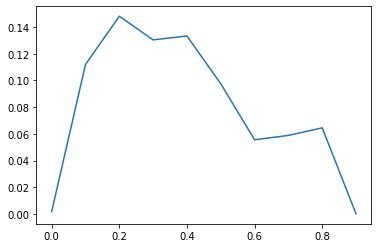

In [320]:
sns.lineplot(ths, fscores)

In [321]:
threshold = 0.2
labels_pred = [1 if np.abs(i) >= threshold else 0 for i in resids]
f1 = metrics.f1_score(labels_true[:len(y_pred)], labels_pred)
print(metrics.confusion_matrix(labels_true[:len(y_pred)], labels_pred))

[[34894    20]
 [   26     4]]


In [ ]:
## visualization

In [264]:
y_corr2 = [max(i,0) for i in y_corr]

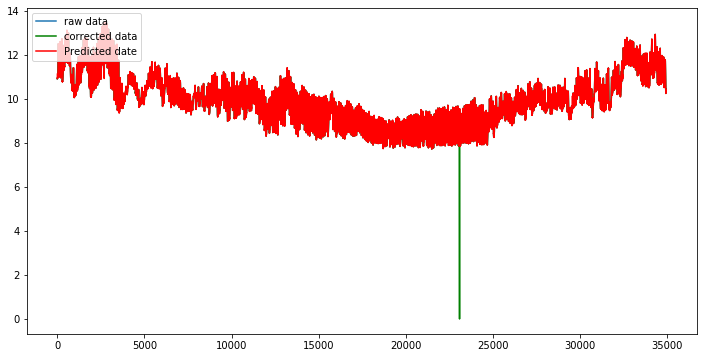

In [322]:
plot_ts(x_raw, y_corr2, y_pred, 1)

In [266]:
np.mean(np.square(np.array(y_corr) - np.array(y_pred)))

20064.90178921129

LocalDateTime
2017-01-15 00:00:00    10.86
Name: ODO, dtype: float64


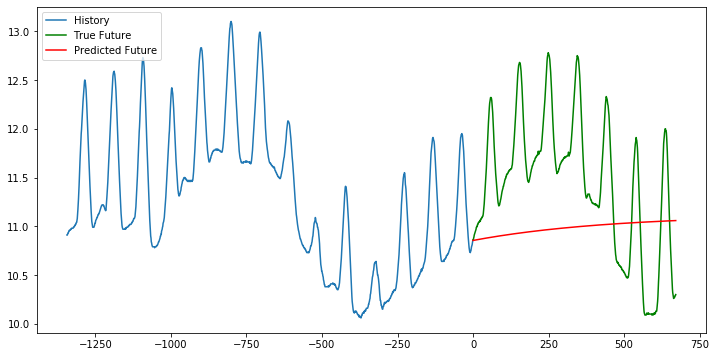

LocalDateTime
2017-01-22 00:00:00    10.31
Name: ODO, dtype: float64


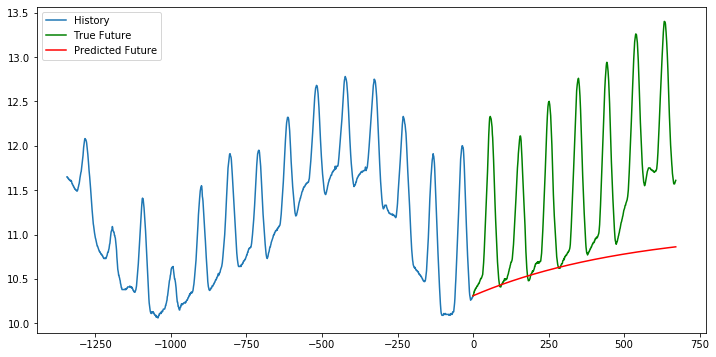

In [89]:
for i in range(0,len(y_pred),ts):
    print(y_train[i][0:1])
    plot_ts(X_train[i], y_train[i], y_pred[i], 1)

# method2: using raw data build arima model

In [95]:
replace_nan = -3

,LocalDateTime,UTCOffset,DateTimeUTC,ODO,CensorCode,QualifierCode
LocalDateTime,,,,,,
2017-01-01 00:00:00,2017-01-01 00:00:00,-7.0,2017-01-01 07:00:00,10.91,nc,NaN
2017-01-01 00:15:00,2017-01-01 00:15:00,-7.0,2017-01-01 07:15:00,10.91,nc,NaN
2017-01-01 00:30:00,2017-01-01 00:30:00,-7.0,2017-01-01 07:30:00,10.92,nc,NaN
2017-01-01 00:45:00,2017-01-01 00:45:00,-7.0,2017-01-01 07:45:00,10.93,nc,NaN
2017-01-01 01:00:00,2017-01-01 01:00:00,-7.0,2017-01-01 08:00:00,10.93,nc,NaN
...,...,...,...,...,...,...
2017-12-31 22:45:00,2017-12-31 22:45:00,-7.0,2018-01-01 05:45:00,11.12,nc,NaN
2017-12-31 23:00:00,2017-12-31 23:00:00,-7.0,2018-01-01 06:00:00,11.14,nc,NaN
2017-12-31 23:15:00,2017-12-31 23:15:00,-7.0,2018-01-01 06:15:00,11.16,nc,NaN


In [113]:
s_join = s_raw.join(s_corr[[category, "QualifierCode"]], on="LocalDateTime", how="outer", lsuffix="_raw")

In [114]:
s_join.reset_index(inplace=True)

In [115]:
s_join.drop(columns=["index"], axis=1, inplace=True)

In [116]:
s_join

,LocalDateTime,ODO_raw,ODO,QualifierCode
0,2017-01-01 00:00:00,10.91,10.910,NaN
1,2017-01-01 00:15:00,10.91,10.910,NaN
2,2017-01-01 00:30:00,10.92,10.920,NaN
3,2017-01-01 00:45:00,10.93,10.930,NaN
4,2017-01-01 01:00:00,10.93,10.930,NaN
...,...,...,...,...
35035,2017-03-06 00:00:00,NaN,10.130,LI
35036,2017-03-13 00:00:00,NaN,9.835,LI
35037,2017-03-20 00:00:00,NaN,9.430,LI
35038,2017-06-15 13:15:00,NaN,9.945,LI


In [110]:
# np.max(s_join["LocalDateTime"]), np.min(s_join["LocalDateTime"])

('2017-12-31 23:45:00', '2017-01-01 00:00:00')

In [111]:
# s_join.fillna(replace_nan)

,LocalDateTime,ODO,ODO_corr
0,2017-01-01 00:00:00,10.91,10.910
1,2017-01-01 00:15:00,10.91,10.910
2,2017-01-01 00:30:00,10.92,10.920
3,2017-01-01 00:45:00,10.93,10.930
4,2017-01-01 01:00:00,10.93,10.930
...,...,...,...
35035,2017-03-06 00:00:00,0.00,10.130
35036,2017-03-13 00:00:00,0.00,9.835
35037,2017-03-20 00:00:00,0.00,9.430
35038,2017-06-15 13:15:00,0.00,9.945


In [148]:
dataset = s_join
train_split = int(len(dataset)*0.8)
train = dataset[:train_split] #history
test = dataset[train_split: len(dataset)] # 

In [155]:
dataset.describe()

,ODO_raw,ODO
count,35025.000000,35040.000000
mean,9.830657,7.831515
std,1.107619,141.457654
min,7.720000,-9999.000000
25%,9.040000,9.040000
50%,9.790000,9.790000
75%,10.560000,10.560000
max,13.460000,13.460000


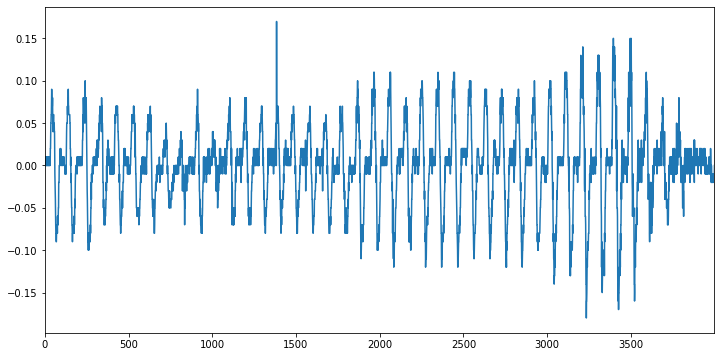

In [128]:
# difference 
diff1 = train["ODO_raw"].diff(1)
diff1.plot(figsize=(12,6))

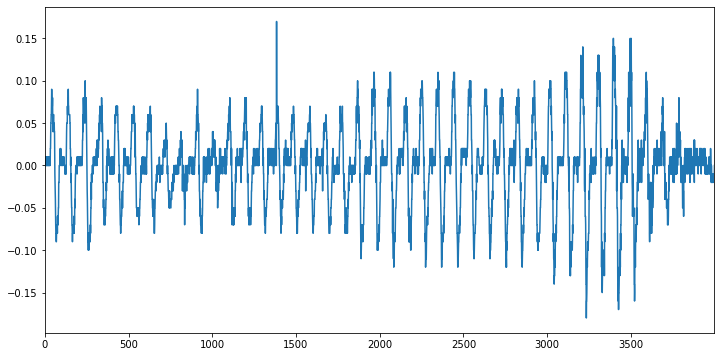

In [129]:
diff2 = train["ODO_raw"].diff(1)
diff2.plot(figsize=(12,6))

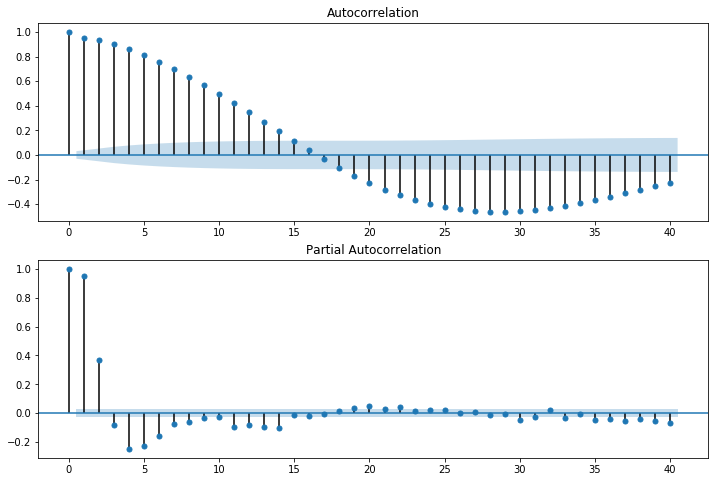

In [131]:
# plot acf and pacf to make sure p,q
diff1.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1,lags=40,ax=ax2)

In [149]:
p,d,q = 1,1,3
model = ARIMA(train["ODO"], order=(p,d,q))
model_fit = model.fit(disp=0)

print(model_fit.summary())

/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.ODO   No. Observations:                28031
Model:                 ARIMA(1, 1, 3)   Log Likelihood             -164154.219
Method:                       css-mle   S.D. of innovations             84.540
Date:                Tue, 14 Apr 2020   AIC                         328320.439
Time:                        08:24:27   BIC                         328369.885
Sample:                             1   HQIC                        328336.356
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.521e-05      0.505     -0.000      1.000      -0.990       0.990
ar.L1.D.ODO  6.109e-05        nan        nan        nan         nan         nan
ma.L1.D.ODO -6.247e-05        nan        nan    

/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)




residuals description:
                  0
count  2.803100e+04
mean   6.302488e-07
std    8.454183e+01
min   -1.000855e+04
25%   -1.994511e-02
50%    5.530351e-05
75%    2.005535e-02
max    1.000841e+04


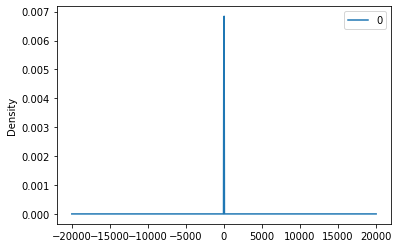

In [150]:
residuals = pd.DataFrame(model_fit.resid)
print('\n\nresiduals description:')
print(residuals.describe())

residuals.plot(kind="kde")

In [151]:
p,d,q = 1,1,1
model = ARIMA(train["ODO"], order=(p,d,q))
model_fit = model.fit(disp=0)

print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
print('\n\nresiduals description:')
print(residuals.describe())


/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.ODO   No. Observations:                28031
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -164154.219
Method:                       css-mle   S.D. of innovations             84.540
Date:                Tue, 14 Apr 2020   AIC                         328316.439
Time:                        08:25:21   BIC                         328349.403
Sample:                             1   HQIC                        328327.050
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.323e-05      0.505     -0.000      1.000      -0.990       0.990
ar.L1.D.ODO  6.119e-05        nan        nan        nan         nan         nan
ma.L1.D.ODO -6.237e-05        nan        nan    

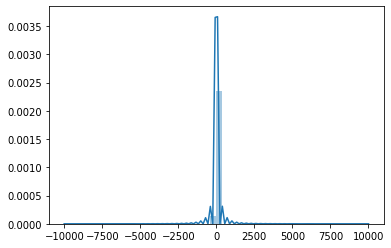

In [152]:
sns.distplot(residuals)